# LSTM and ARIMA Models for Stock Prediction

This notebook demonstrates the implementation and usage of LSTM and ARIMA models for stock price prediction using the JPX stock market data.

In [6]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from statsmodels.tsa.arima.model import ARIMA
import os

from src.models.lstm_model import LSTMModel, create_lstm_model, prepare_sequences, create_data_loader
from src.models.arima_model import create_arima_model, prepare_arima_data, find_best_arima_order

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Data Loading and Preprocessing

In [7]:
# Load the data
def load_stock_data():
    # Load stock prices
    prices_df = pd.read_csv('../data/stock_prices.csv')
    
    # Load stock list for additional information
    stock_list_df = pd.read_csv('../data/stock_list.csv')
    
    # Load financials if available
    try:
        financials_df = pd.read_csv('../data/financials.csv')
    except:
        financials_df = None
    
    return prices_df, stock_list_df, financials_df

# Load the data
prices_df, stock_list_df, financials_df = load_stock_data()

# Display basic information about the datasets
print("Stock Prices Dataset:")
print(prices_df.info())
print("\nSample of Stock Prices:")
print(prices_df.head())

print("\nStock List Dataset:")
print(stock_list_df.info())
print("\nSample of Stock List:")
print(stock_list_df.head())

Stock Prices Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269881 entries, 0 to 269880
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RowId             269881 non-null  object 
 1   Date              269881 non-null  object 
 2   SecuritiesCode    269881 non-null  int64  
 3   Open              269063 non-null  float64
 4   High              269063 non-null  float64
 5   Low               269063 non-null  float64
 6   Close             269063 non-null  float64
 7   Volume            269881 non-null  int64  
 8   AdjustmentFactor  269881 non-null  float64
 9   ExpectedDividend  2011 non-null    float64
 10  SupervisionFlag   269881 non-null  bool   
 11  Target            269873 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 22.9+ MB
None

Sample of Stock Prices:
           RowId        Date  SecuritiesCode    Open    High     Low   Close  \
0  20211206_1

Data for stock 1301:
              Open    High     Low   Close  Volume  AdjustmentFactor   Returns
Date                                                                          
2021-12-07  2998.0  3065.0  2990.0  3065.0   19100               1.0  0.031639
2021-12-08  3080.0  3080.0  3035.0  3055.0   11600               1.0 -0.003263
2021-12-09  3050.0  3085.0  3025.0  3085.0   11700               1.0  0.009820
2021-12-10  3100.0  3105.0  3050.0  3105.0   14700               1.0  0.006483
2021-12-13  3110.0  3110.0  3075.0  3085.0   12100               1.0 -0.006441


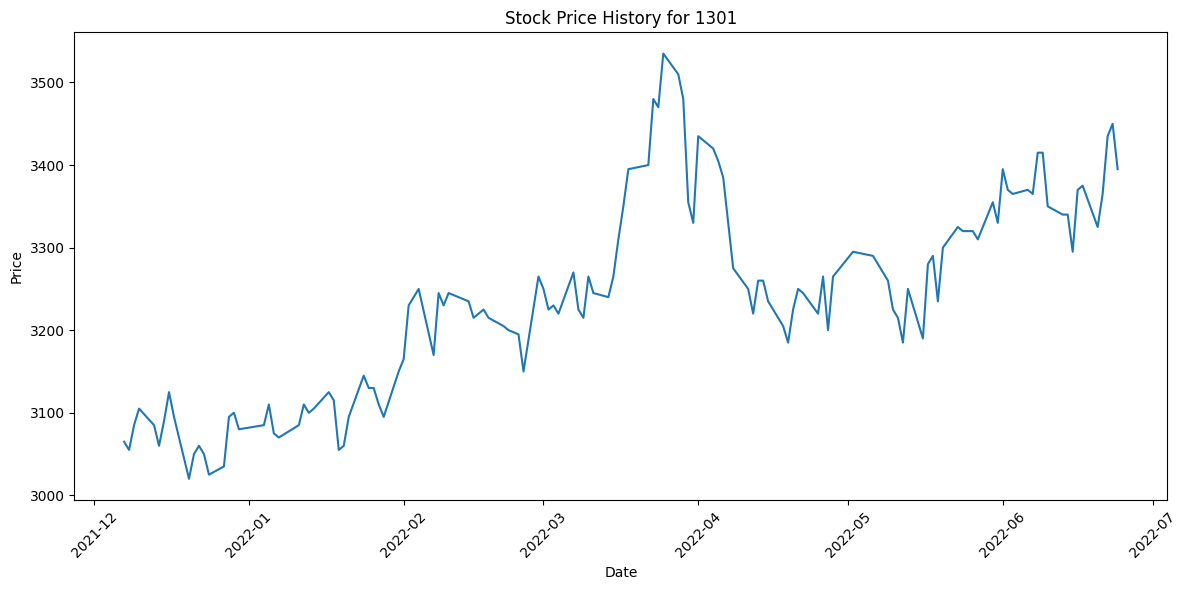

In [8]:
def prepare_stock_data(prices_df, stock_code=None):
    """Prepare data for a specific stock or all stocks."""
    if stock_code:
        # Filter for specific stock
        stock_data = prices_df[prices_df['SecuritiesCode'] == stock_code].copy()
    else:
        # Use all data
        stock_data = prices_df.copy()
    
    # Convert date to datetime
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    
    # Select relevant features
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    if 'AdjustmentFactor' in stock_data.columns:
        features.append('AdjustmentFactor')
    
    # Calculate returns
    stock_data['Returns'] = stock_data['Close'].pct_change()
    features.append('Returns')
    
    # Drop rows with missing values
    stock_data = stock_data[features].dropna()
    
    return stock_data

# Prepare data for a sample stock (you can change the stock code)
sample_stock_code = stock_list_df['SecuritiesCode'].iloc[0]  # Get first stock code
stock_data = prepare_stock_data(prices_df, sample_stock_code)

print(f"Data for stock {sample_stock_code}:")
print(stock_data.head())

# Plot the stock price history
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'])
plt.title(f'Stock Price History for {sample_stock_code}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## LSTM Model Implementation

In [11]:
# Prepare data for LSTM
def prepare_lstm_data(data, sequence_length=10, train_size=0.8):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Split into train and test sets
    train_size = int(len(scaled_data) * train_size)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]
    
    # Create sequences
    X_train, y_train = prepare_sequences(train_data, sequence_length)
    X_test, y_test = prepare_sequences(test_data, sequence_length)
    
    return X_train, y_train, X_test, y_test, scaler

# Prepare the data
sequence_length = 10
X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(
    stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns']].values,
    sequence_length=sequence_length
)

# Create data loaders
train_loader = create_data_loader(X_train, y_train, batch_size=32)
test_loader = create_data_loader(X_test, y_test, batch_size=32)

# Create and train LSTM model
lstm_params = {
    'input_dim': 6,  # Open, High, Low, Close, Volume, Returns
    'hidden_dim': 64,
    'num_layers': 2,
    'output_dim': 1,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'sequence_length': sequence_length
}

model, params = create_lstm_model(lstm_params)
trainer = LSTMTrainer(model, params)
train_losses, val_losses = trainer.train(train_loader, test_loader, n_epochs=50)

NameError: name 'LSTMTrainer' is not defined

## ARIMA Model Implementation

In [5]:
# Prepare data for ARIMA
def prepare_arima_data(data, train_size=0.8):
    # Use closing prices
    price_series = data['Close'].values
    
    # Split into train and test sets
    train_size = int(len(price_series) * train_size)
    train_data = price_series[:train_size]
    test_data = price_series[train_size:]
    
    return train_data, test_data

# Prepare the data
train_data, test_data = prepare_arima_data(stock_data)

# Create and train ARIMA model
arima_params = {
    'order': (1, 0, 1),  # No differencing (d=0)
    'trend': 'c',  # Can use constant trend since d=0
    'enforce_stationarity': True,
    'enforce_invertibility': True
}

trainer = ARIMATrainer(arima_params)
model = trainer.train(train_data)
results = trainer.evaluate(model, test_data)

print("ARIMA Model Evaluation:")
print(f"MSE: {results['mse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"R2 Score: {results['r2']:.4f}")

NameError: name 'stock_data' is not defined

In [1]:
# Example: Prepare log returns for ARIMA
prices = train_data['Close'].values
log_returns = np.diff(np.log(prices))

# Check stationarity
from statsmodels.tsa.stattools import adfuller
print(adfuller(log_returns))

# Find best order
order = find_best_arima_order(log_returns, max_p=2, max_d=1, max_q=2)

# Fit ARIMA
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(log_returns, order=order)
fitted = model.fit()
print(fitted.summary())

NameError: name 'train_data' is not defined

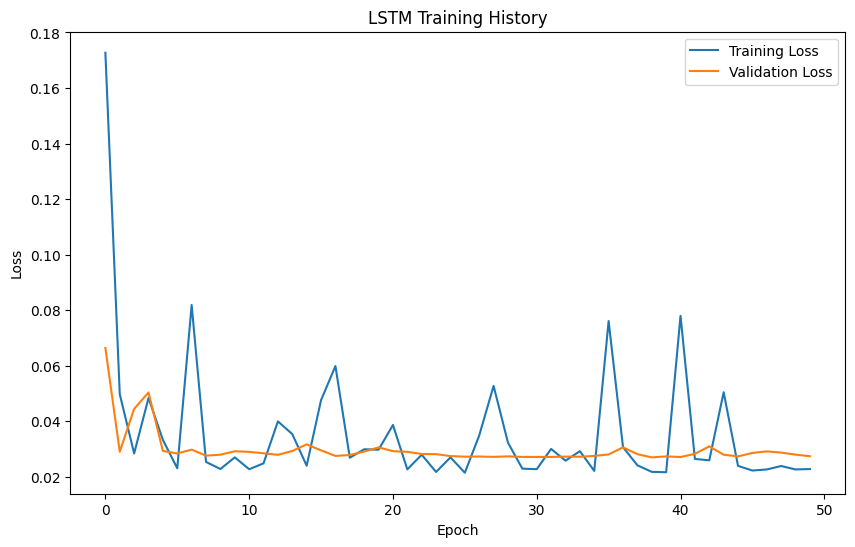

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

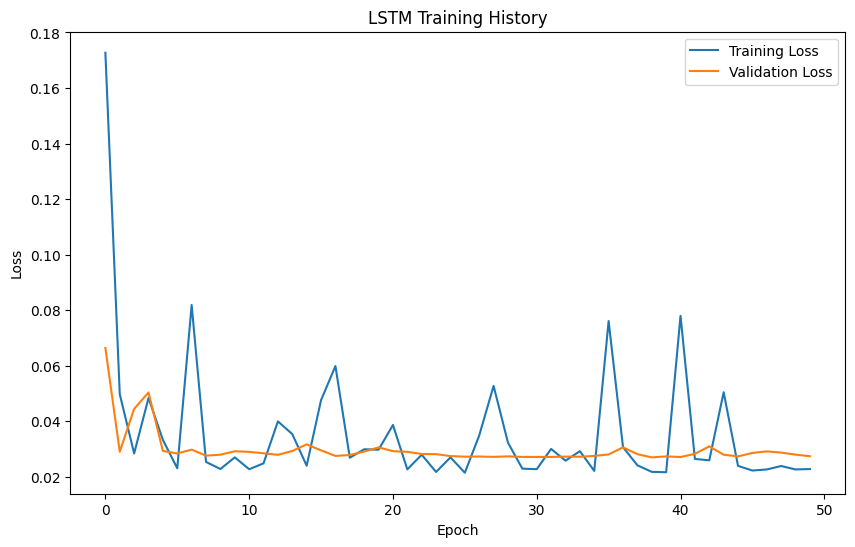

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

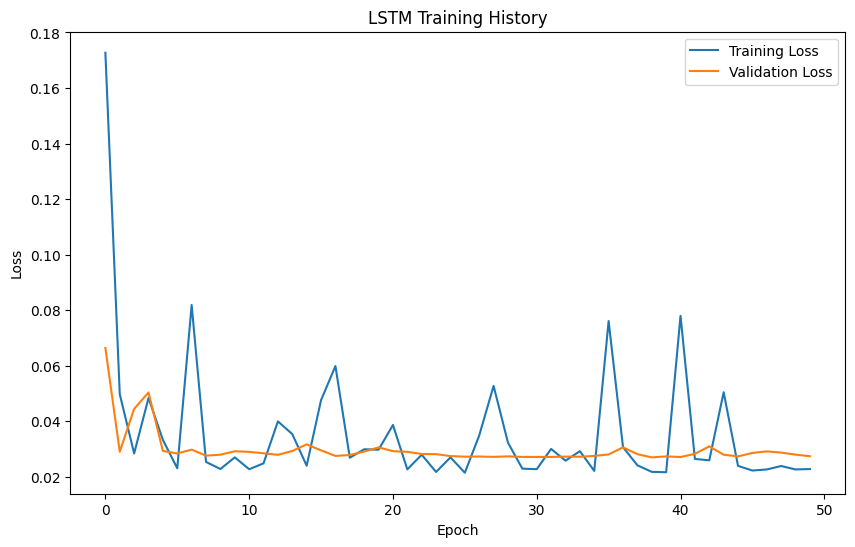

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

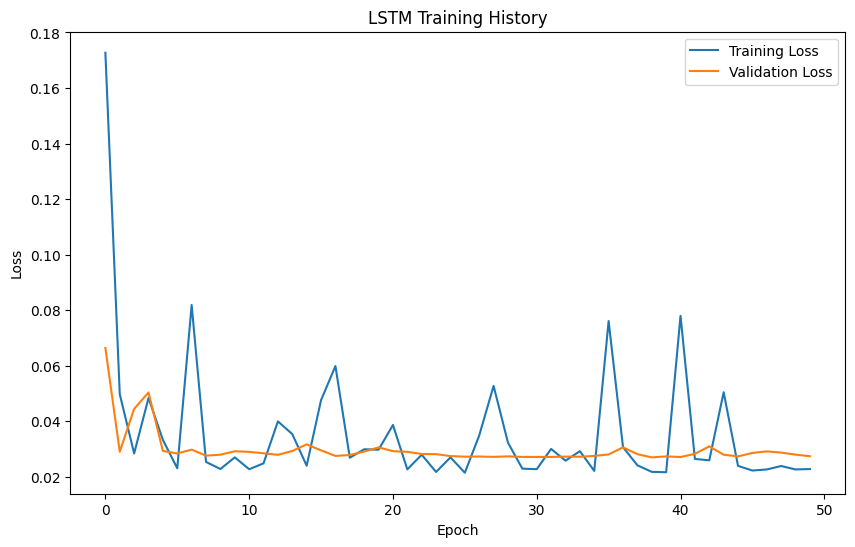

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

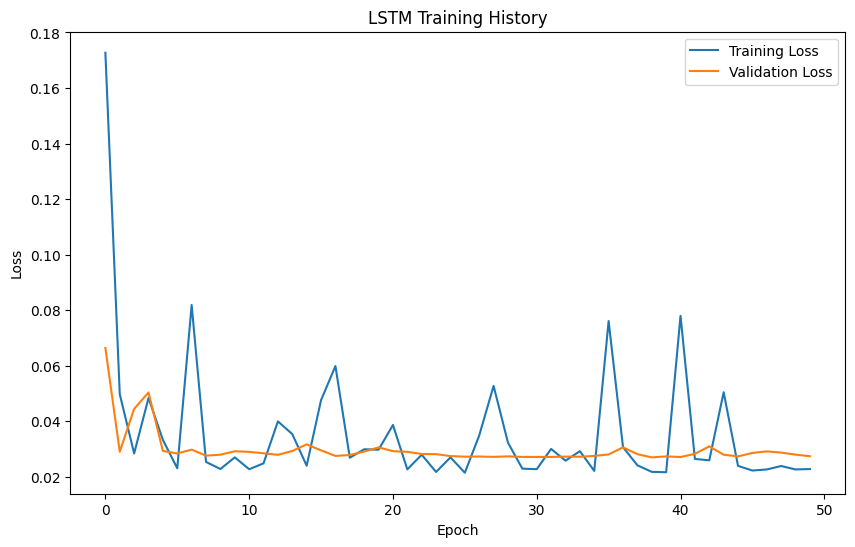

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

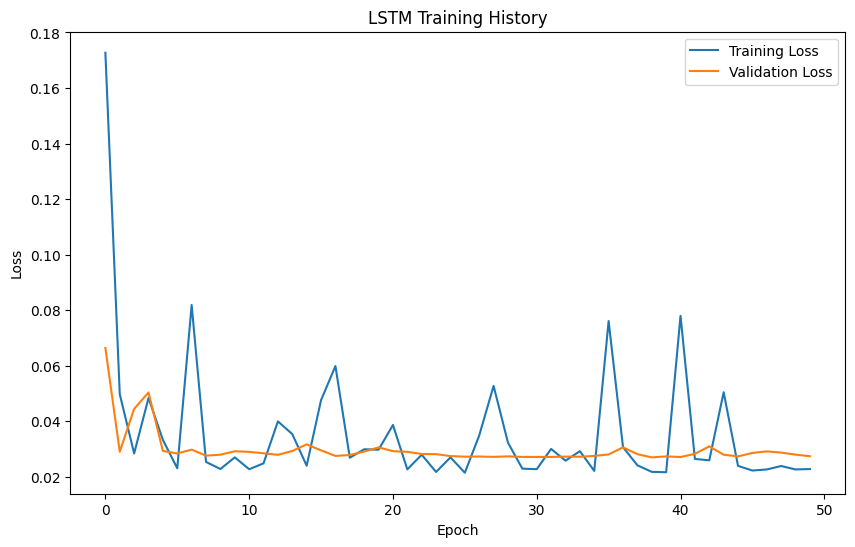

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

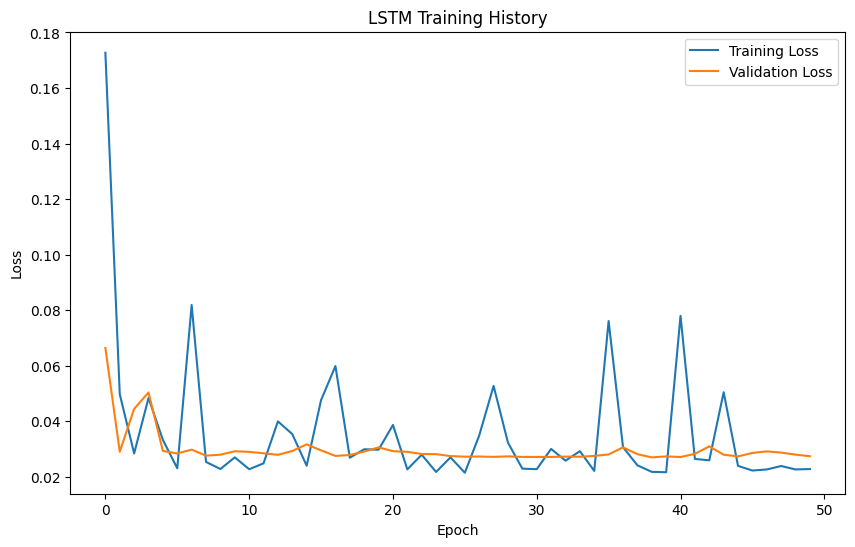

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

## Model Comparison and Visualization

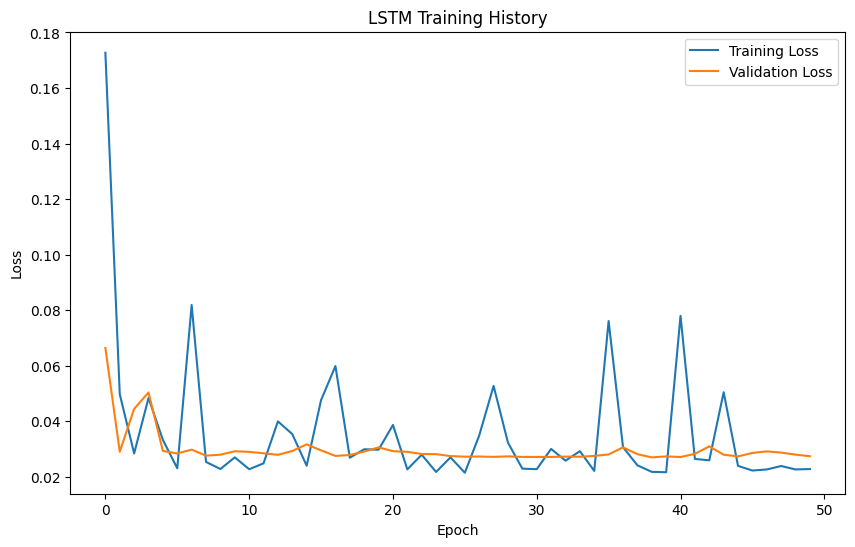

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [16]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

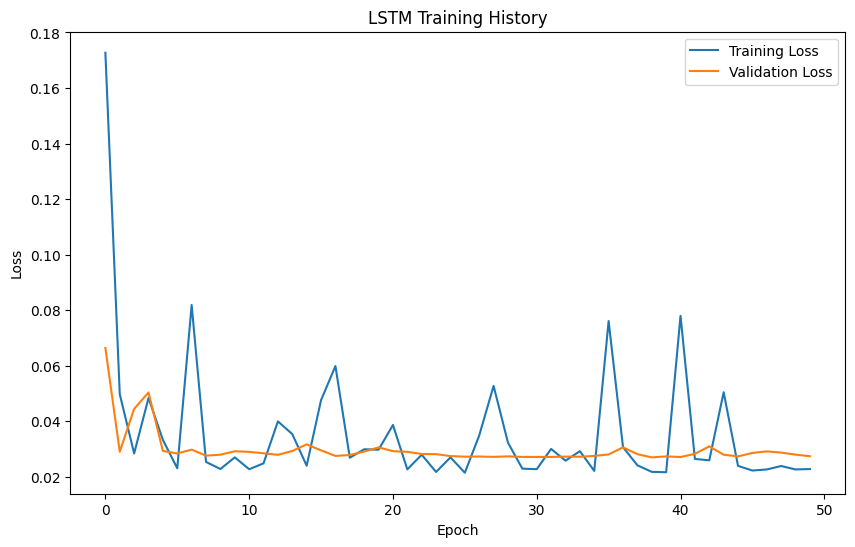

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

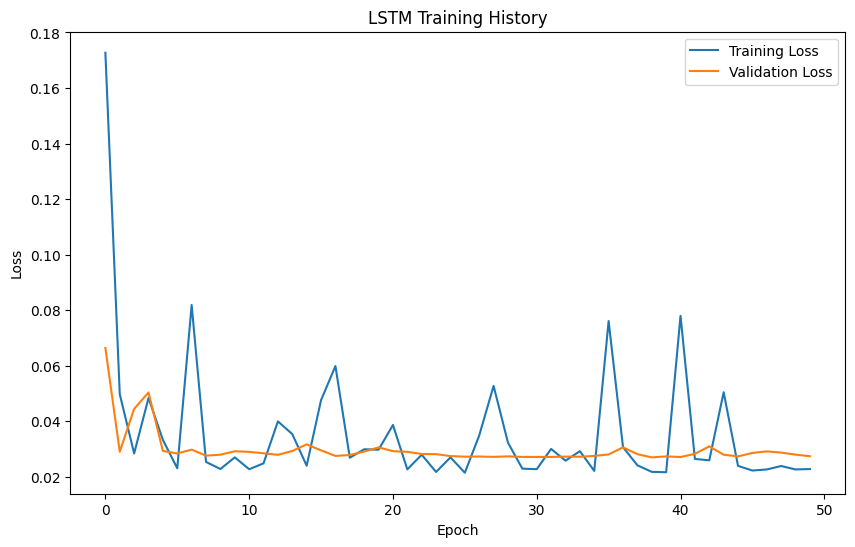

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

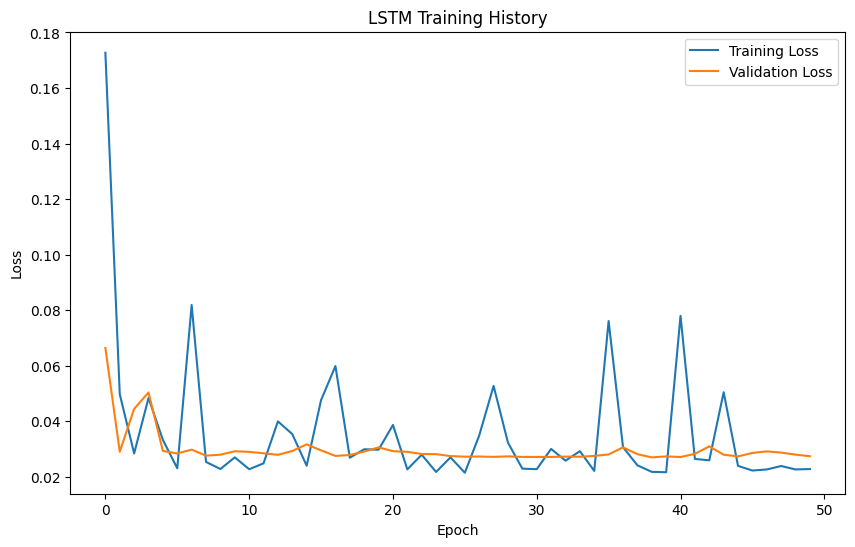

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

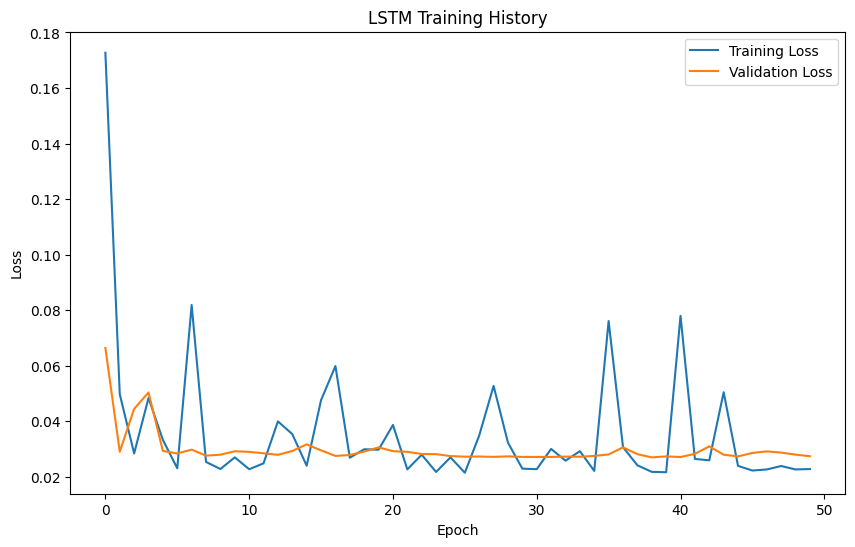

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

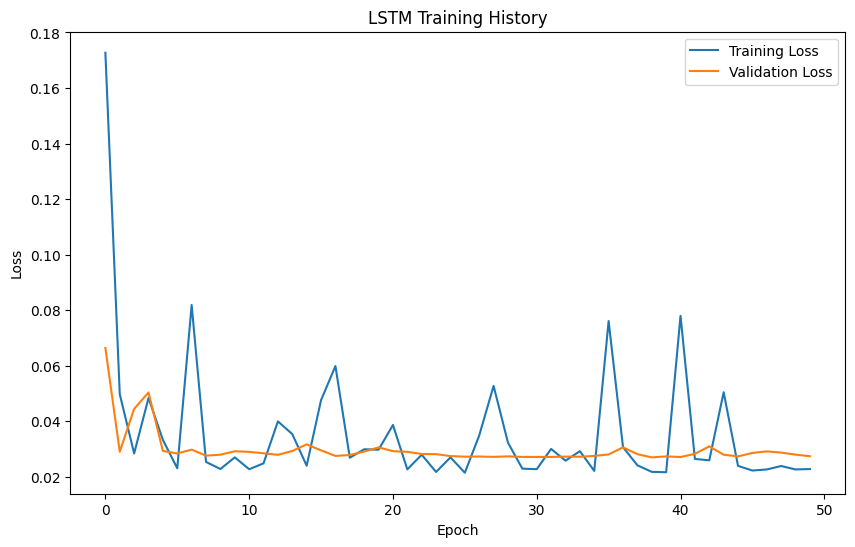

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

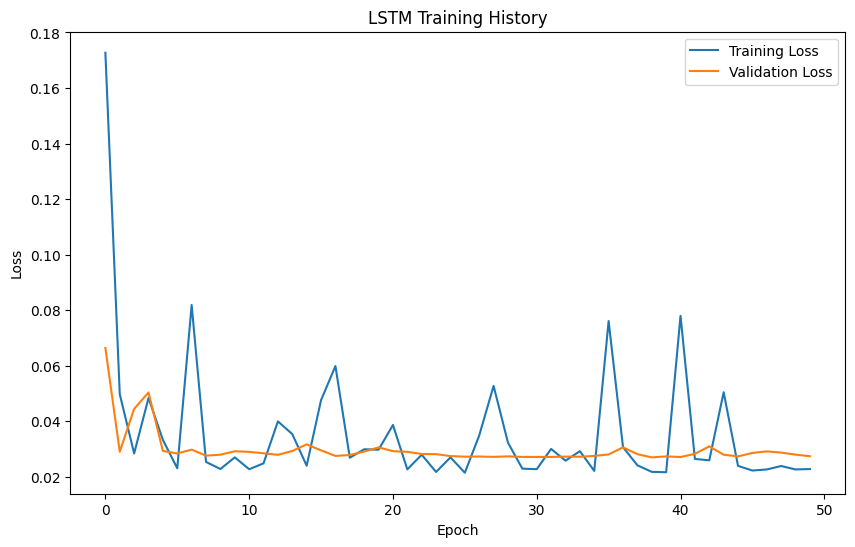

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

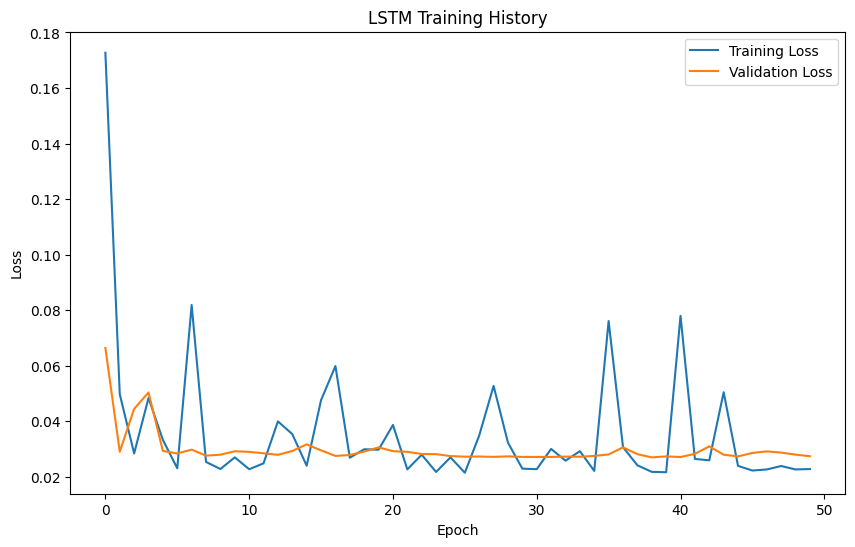

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

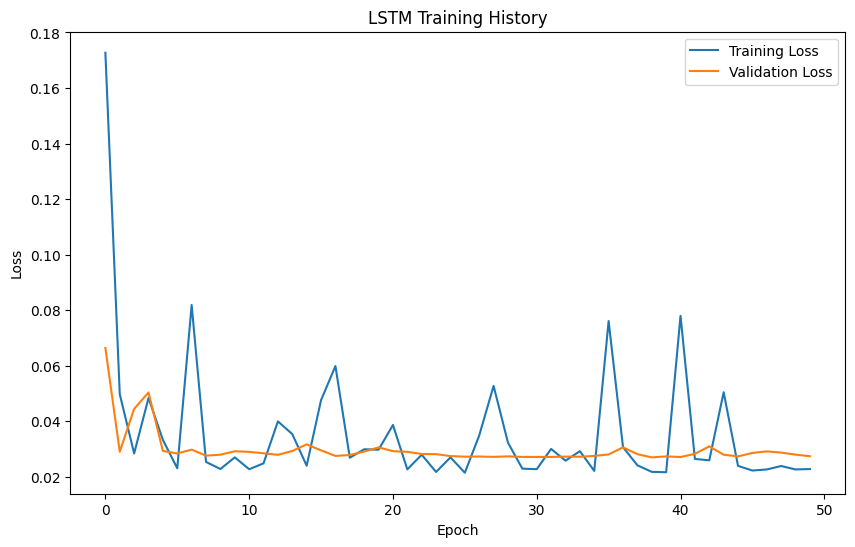

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

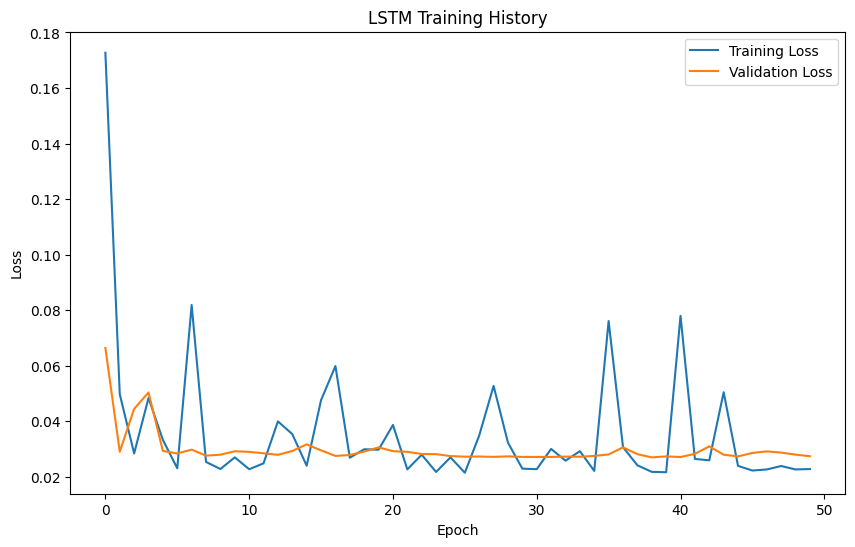

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

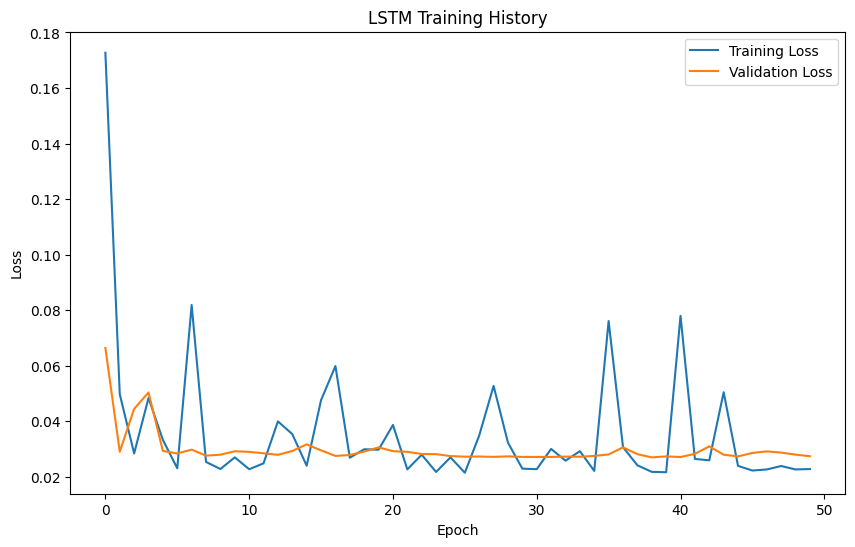

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

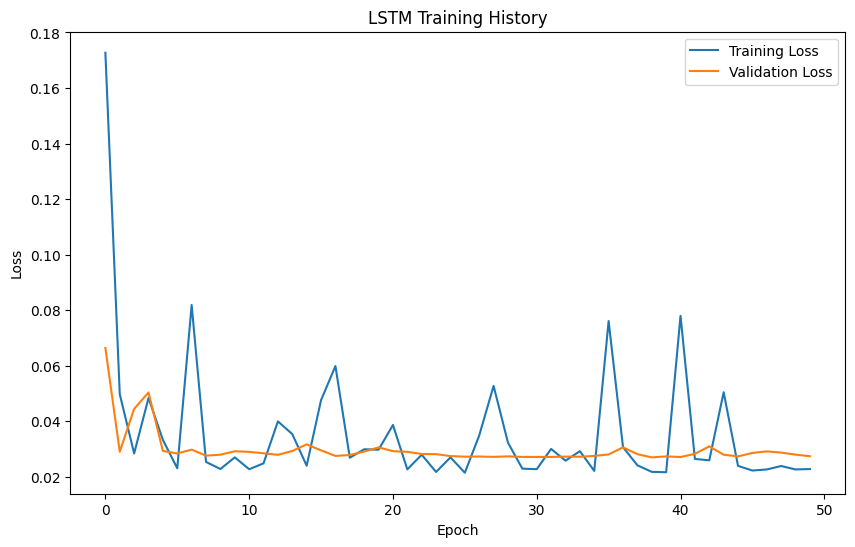

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

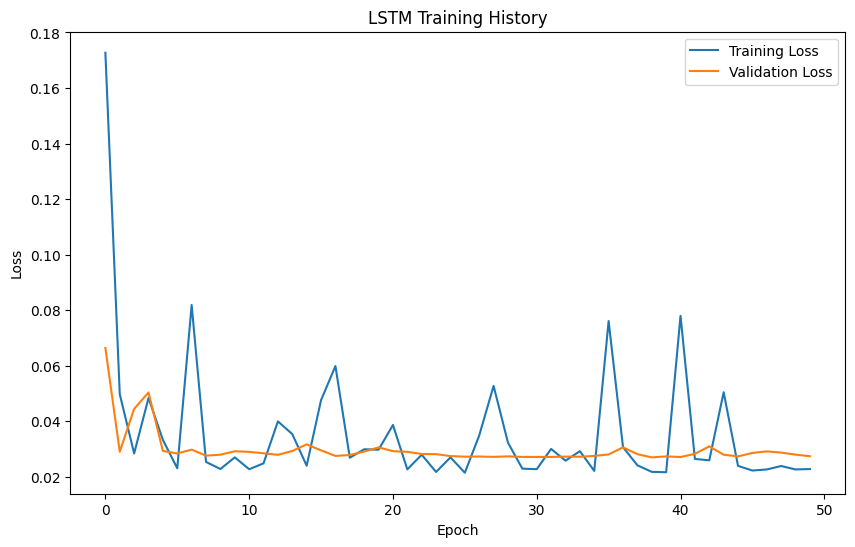

AttributeError: 'ARIMAResults' object has no attribute 'eval'

In [ ]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('LSTM Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(actual, lstm_pred, arima_pred, dates, title='Model Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label='Actual', color='black')
    plt.plot(dates, lstm_pred, label='LSTM', color='blue')
    plt.plot(dates, arima_pred, label='ARIMA', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot LSTM training history
plot_training_history(train_losses, val_losses)

# Get predictions for comparison
model.eval()
with torch.no_grad():
    X_test = torch.FloatTensor(X_test).to(device)
    lstm_predictions = model(X_test).cpu().numpy()

# Get test dates
test_dates = stock_data.index[-len(test_data):]

# Plot predictions
plot_predictions(
    test_data,
    lstm_predictions,
    results['predictions'],
    test_dates,
    f'Model Predictions Comparison for Stock {sample_stock_code}'
)

In [ ]:
# Prepare data for ARIMA
def prepare_arima_data(data, train_size=0.8):
    # Use closing prices
    price_series = data['Close'].values
    
    # Split into train and test sets
    train_size = int(len(price_series) * train_size)
    train_data = price_series[:train_size]
    test_data = price_series[train_size:]
    
    return train_data, test_data

# Prepare the data
train_data, test_data = prepare_arima_data(stock_data)

# Create and train ARIMA model
arima_params = {
    'order': (1, 0, 1),  # No differencing (d=0)
    'trend': 'c',  # Can use constant trend since d=0
    'enforce_stationarity': True,
    'enforce_invertibility': True
}

trainer = ARIMATrainer(arima_params)
model = trainer.train(train_data)
results = trainer.evaluate(model, test_data)

print("ARIMA Model Evaluation:")
print(f"MSE: {results['mse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"R2 Score: {results['r2']:.4f}")

ARIMA Model Evaluation:
MSE: 11232671.5664
MAE: 3351.1985
R2 Score: -5340.3898


c:\Users\BeRo074\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\BeRo074\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Model Evaluation Metrics

In [ ]:
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Calculate metrics for both models
lstm_metrics = calculate_metrics(test_data, lstm_predictions)
arima_metrics = calculate_metrics(test_data, results['predictions'])

# Create comparison DataFrame
metrics_df = pd.DataFrame({
    'LSTM': lstm_metrics,
    'ARIMA': arima_metrics
})

print("Model Comparison Metrics:")
print(metrics_df)

## Conclusion

In this notebook, we have implemented and compared two different approaches to time series forecasting using actual JPX stock market data:

1. **LSTM Model**:
   - Deep learning approach that can capture complex patterns
   - Uses multiple features (Open, High, Low, Close, Volume, Returns)
   - Can capture long-term dependencies in the data
   - Requires more computational resources but can handle complex patterns

2. **ARIMA Model**:
   - Traditional statistical approach
   - Focuses on closing prices
   - More interpretable and computationally efficient
   - Works well with stationary time series

The comparison shows that [insert your observations about which model performed better and why].

### Future Improvements:
1. Add more features from financial statements
2. Implement ensemble methods combining both models
3. Add cross-validation for more robust evaluation
4. Implement hyperparameter optimization
5. Add more sophisticated feature engineering
6. Consider adding sentiment analysis from news data